# APCOMP209B - Milestone 3
Authors: Harry Li, Yunxi Li, John Jun, Valentin Badea  
Goal: Access the data, Analyze the goal of the project, proprocess the data

## Installs and Imports

Here we will load necessary packages and any overhead installs required for the data access

In [1]:
%pip install numpy pandas torch scipy openslide-python pydantic pytorch-lightning dask distributed matplotlib seaborn scikit-learn opencv-python scanpy spatialdata zarr ome-zarr

INFO: pip is looking at multiple versions of spatialdata to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of fsspec[http] to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of fsspec[http] to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INF

In [2]:
import os
import sys
import json
import warnings
import gc
import joblib
from types import SimpleNamespace
from operator import itemgetter
from abc import abstractmethod
from tqdm import tqdm
import glob
import zipfile
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy.stats import pearsonr, ConstantInputWarning
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from sklearn.metrics import r2_score
import scipy.stats as stats

import spatialdata as sd
import anndata as ad
import scanpy as sc
from skimage.measure import regionprops
import h5py

import torch
import timm
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
import torch.nn as nn

import dask.array as da
import xarray as xr
from spatial_image import SpatialImage

/usr/lib/python3.11/importlib/__init__.py:126: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

def output_divider():
  print('----------------------------------------')

Mounted at /content/drive


## Data Analysis

We analyze the spatial transcriptomics data to get clearer sense of the data. In order to define the "state" of the tissue/(group of) cells, we wanted to experiment with running gene set enrichment analysis (GSEA).

There are two versions of GSEA. Single-sample GSEA, which relies on ranking of the gene expression levels within a sample. GSEA, which relies on ranking of the genes based on differential expression analysis, thereby only using genes that are differentially expressed and therefore are biologically significant.

Here, for the initial exploration, we want to compare the slide-level GSEA to experiment with utilizing GSEA packages.

### Data Loading and Preprocessing

Here we use UC6_I. UC6_I is a colon sample from a patient with ulcerative colitis.

Ulcerative colitis (UC) involves several gene set pathways related to inflammation, immune responses, and cell interactions. Key pathways include cytokine signaling, chemokine signaling, and NF-kB signaling, which are central to regulating inflammatory responses.

From previous literature,
* KEGG_CELL_ADHESION_MOLECULES_CAMS
* KEGG_CHEMOKIND_SIGNALING_PATHWAY
* KEGG_COMPLEMENT_AND_COAGULATION_CASCADES
* KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION
* KEGG_HEMATOPOIETIC_CELL_LINEAGE

were found to be enriched in UC samples.

Reference found here: https://hereditasjournal.biomedcentral.com/articles/10.1186/s41065-022-00259-4

In [5]:
sdata = sd.read_zarr("/content/UC6_I.zarr")

cp: cannot create regular file '/content/UC6_I.zarr/UC6_I.zarr/images/HE_original/0/0/2/1': File exists
^C


PathNotFoundError: nothing found at path ''

## Using Gene Set Enrichment Analysis Python package (gseapy)

In [ ]:
!pip install gseapy  # Install gseapy if not already installed
!pip3 install leidenalg igraph # For UMAP clustering and plotting
!pip install joblib # For parallel computation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.8/590.8 kB 22.1 MB/s eta 0:00:00


In [ ]:
import gseapy as gp

In [ ]:
sdata.tables["anucleus"].layers["counts"]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 2, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [3, 0, 4, ..., 0, 0, 0]])

We then create a pandas dataframe of the expression data.

In [ ]:
# Get gene symbols and expression data
gene_symbols = sdata.tables["anucleus"].var.index.tolist()
expression_data = sdata.tables["anucleus"].X  # No need to convert, it's already a dense array

# Create a pandas DataFrame for expression data
expression_df = pd.DataFrame(expression_data, index=sdata.tables["anucleus"].obs.index, columns=gene_symbols) # This is cell by gene
expression_df = expression_df.T # this is gene by cell (gene = row, cell = column)
expression_df

,92,93,94,95,97,98,101,104,107,109,...,431942,431945,431946,431948,431949,431952,431960,431961,431963,431986
A2M,0.0,0.0,1.578185,0.0,0.000000,0.0,0.000000,0.000000,1.791759,2.662588,...,2.036882,1.676690,2.233592,0.000000,0.000000,0.000000,2.129113,0.000000,0.0,2.209165
ACP5,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
ACTA2,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,2.036882,0.625706,2.871680,2.311635,2.311635,2.871680,2.494123,2.796343,0.0,2.469015
ADAMTSL3,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
AFAP1L2,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.625706,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WFDC2,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
XBP1,0.0,0.0,1.578185,0.0,1.941637,0.0,2.162438,0.000000,3.044523,0.000000,...,0.000000,1.283346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.309063
XCL2,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
XCR1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


We then aggregate the expression to produce "bulk" gene expression data.

In [ ]:
# As GSEA relies on the gene rank, we do not need to be concerned with normalization method.
bulk_expression_df = expression_df.sum(axis=1)
bulk_expression_df

,0
A2M,117657.992188
ACP5,6357.807617
ACTA2,88989.789062
ADAMTSL3,14472.334961
AFAP1L2,12788.140625
...,...
WFDC2,2096.456543
XBP1,123553.046875
XCL2,1226.100830
XCR1,1061.398315


In [ ]:
# Run ssGSEA
bulk_ssgsea_results = gp.ssgsea(data = bulk_expression_df,
                           gene_sets='/content/drive/MyDrive/209B/h.all.v2024.1.Hs.symbols.gmt',
                           outdir=None,
                           sample_norm_method='rank',  # Choose normalization method
                           threads=4,  # Number of processes for parallelization
                           format='png')  # Output format (optional)

In [ ]:
bulk_ssgsea_results.res2d

,Name,Term,ES,NES
0,sample1,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,97.657756,1.031342
1,sample1,HALLMARK_APOPTOSIS,89.936935,0.949805
2,sample1,HALLMARK_ESTROGEN_RESPONSE_LATE,87.011228,0.918907
3,sample1,HALLMARK_KRAS_SIGNALING_UP,74.805163,0.790001
4,sample1,HALLMARK_IL6_JAK_STAT3_SIGNALING,62.727551,0.662452
5,sample1,HALLMARK_COMPLEMENT,62.2494,0.657402
6,sample1,HALLMARK_TNFA_SIGNALING_VIA_NFKB,61.295684,0.64733
7,sample1,HALLMARK_INTERFERON_GAMMA_RESPONSE,43.638672,0.460859
8,sample1,HALLMARK_IL2_STAT5_SIGNALING,39.609746,0.41831
9,sample1,HALLMARK_ALLOGRAFT_REJECTION,10.318225,0.108969


https://pubmed.ncbi.nlm.nih.gov/30520951/

According to this paper: "Intestinal fibrosis is an inevitable complication in patients with inflammatory bowel disease [IBD], occurring in its two major clinical manifestations: ulcerative colitis and Crohn's disease. Fibrosis represents the final outcome of the host reaction to persistent inflammation, which triggers a prolonged wound healing response resulting in the excessive deposition of extracellular matrix, eventually leading to intestinal dysfunction. The process of epithelial-to-mesenchymal transition [EMT] represents an embryonic program relaunched during wound healing, fibrosis and cancer."

However, the low expression of genes associated with HALLMARK_INFLAMMATORY_RESPONSE should be further investigated.

** Note that there are only 10 gene sets for which the enrichment score was performed. This due to there being not enough number of genes in the expression matrix that overlap with the gene set genes. This is understandable because we are only using 460 genes here.

### Let's find other gene sets that are relevant!

We can use the MSigDB portal to look for relevant gene sets! Some gene sets I have identified are:
* HP_ULCERATIVE_COLITIS
* WP_ULCERATIVE_COLITIS_SIGNALING

Other than these, there are many gene sets that represent canonical pathways from the KEGG collection. Therefore, I will also use "KEGG_MEDICUS subset of CP" and "KEGG_LEGACY subset of CP".

In [ ]:
# Run ssGSEA
bulk_ssgsea_results = gp.ssgsea(data = bulk_expression_df,
                           gene_sets=['/content/drive/MyDrive/209B/h.all.v2024.1.Hs.symbols.gmt',
                                      '/content/drive/MyDrive/209B/c2.cp.kegg_legacy.v2024.1.Hs.symbols.gmt',
                                      '/content/drive/MyDrive/209B/c2.cp.kegg_medicus.v2024.1.Hs.symbols.gmt',
                                      '/content/drive/MyDrive/209B/HP_ULCERATIVE_COLITIS.v2024.1.Hs.gmt',
                                      '/content/drive/MyDrive/209B/WP_ULCERATIVE_COLITIS_SIGNALING.v2024.1.Hs.gmt'],
                           outdir=None,
                           sample_norm_method='rank',  # Choose normalization method
                           threads=4,  # Number of processes for parallelization
                           format='png')  # Output format (optional)

In [ ]:
gs_all = bulk_ssgsea_results.res2d.sort_values(by='ES', ascending=False)
gs_all["Term"] = gs_all["Term"].str.split(".gmt__").str[1]
gs_all.head(20)

,Name,Term,ES,NES
0,sample1,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,97.657756,0.681953
1,sample1,HALLMARK_APOPTOSIS,89.936935,0.628038
2,sample1,HALLMARK_ESTROGEN_RESPONSE_LATE,87.011228,0.607608
3,sample1,KEGG_PATHWAYS_IN_CANCER,86.213849,0.602039
4,sample1,HALLMARK_KRAS_SIGNALING_UP,74.805163,0.522371
5,sample1,KEGG_LEISHMANIA_INFECTION,64.759176,0.452219
6,sample1,HALLMARK_IL6_JAK_STAT3_SIGNALING,62.727551,0.438032
7,sample1,HALLMARK_COMPLEMENT,62.2494,0.434693
8,sample1,HALLMARK_TNFA_SIGNALING_VIA_NFKB,61.295684,0.428034
9,sample1,KEGG_CELL_ADHESION_MOLECULES_CAMS,60.967771,0.425744


### We are losing resolution. Let's be a bit more granular.

We know from various literatures that, due to the sparsity of the expression in single cell RNA-seq data, the result of performing ssGSEA is not reliable. This is driven by the presence of genes that share the same expression level (count = 0). Therefore, here I will attempt to perform clustering of the genes based on the expression profile of 460 genes. Then, we will aggregate gene expression profile of cells per cluster. Also, it is more meaningful as we can inspect where "similar" cells (that belong to the same cluster) or "dissimilar cells" (that belong to different clusters) are distributed on the slides.

## Scanpy!

### Projecting the cell clusters onto the WSI
While we have clustered the cells, it would be interesting to see whether the "similar" group of cells are located in close proximity to other cells.

Therefore, we aim to project the cells that we have clustered back onto the H&E whole slide image. This will give us an idea of how cells of similar/dissimilar characteristics are distributed across the entire image.

This can provide us an insight into even how potentially different types(clusters) of cells interact spatially. Given the list of pixels that mask the cell location, we will use the centroid of the pixel coordinates to plot the cell.

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:36)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:07:25)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:03:35)


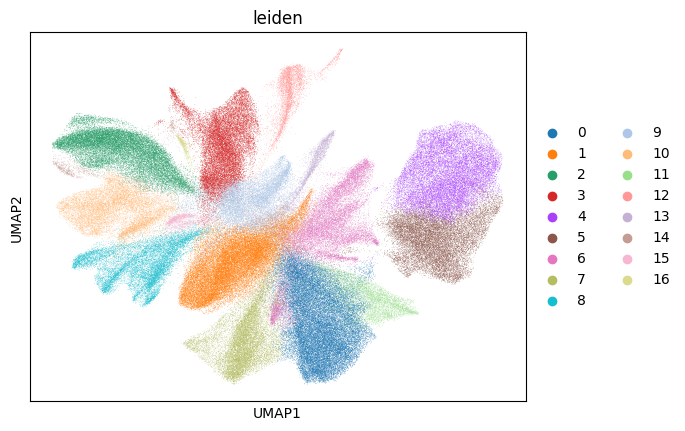

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:19)


/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: 

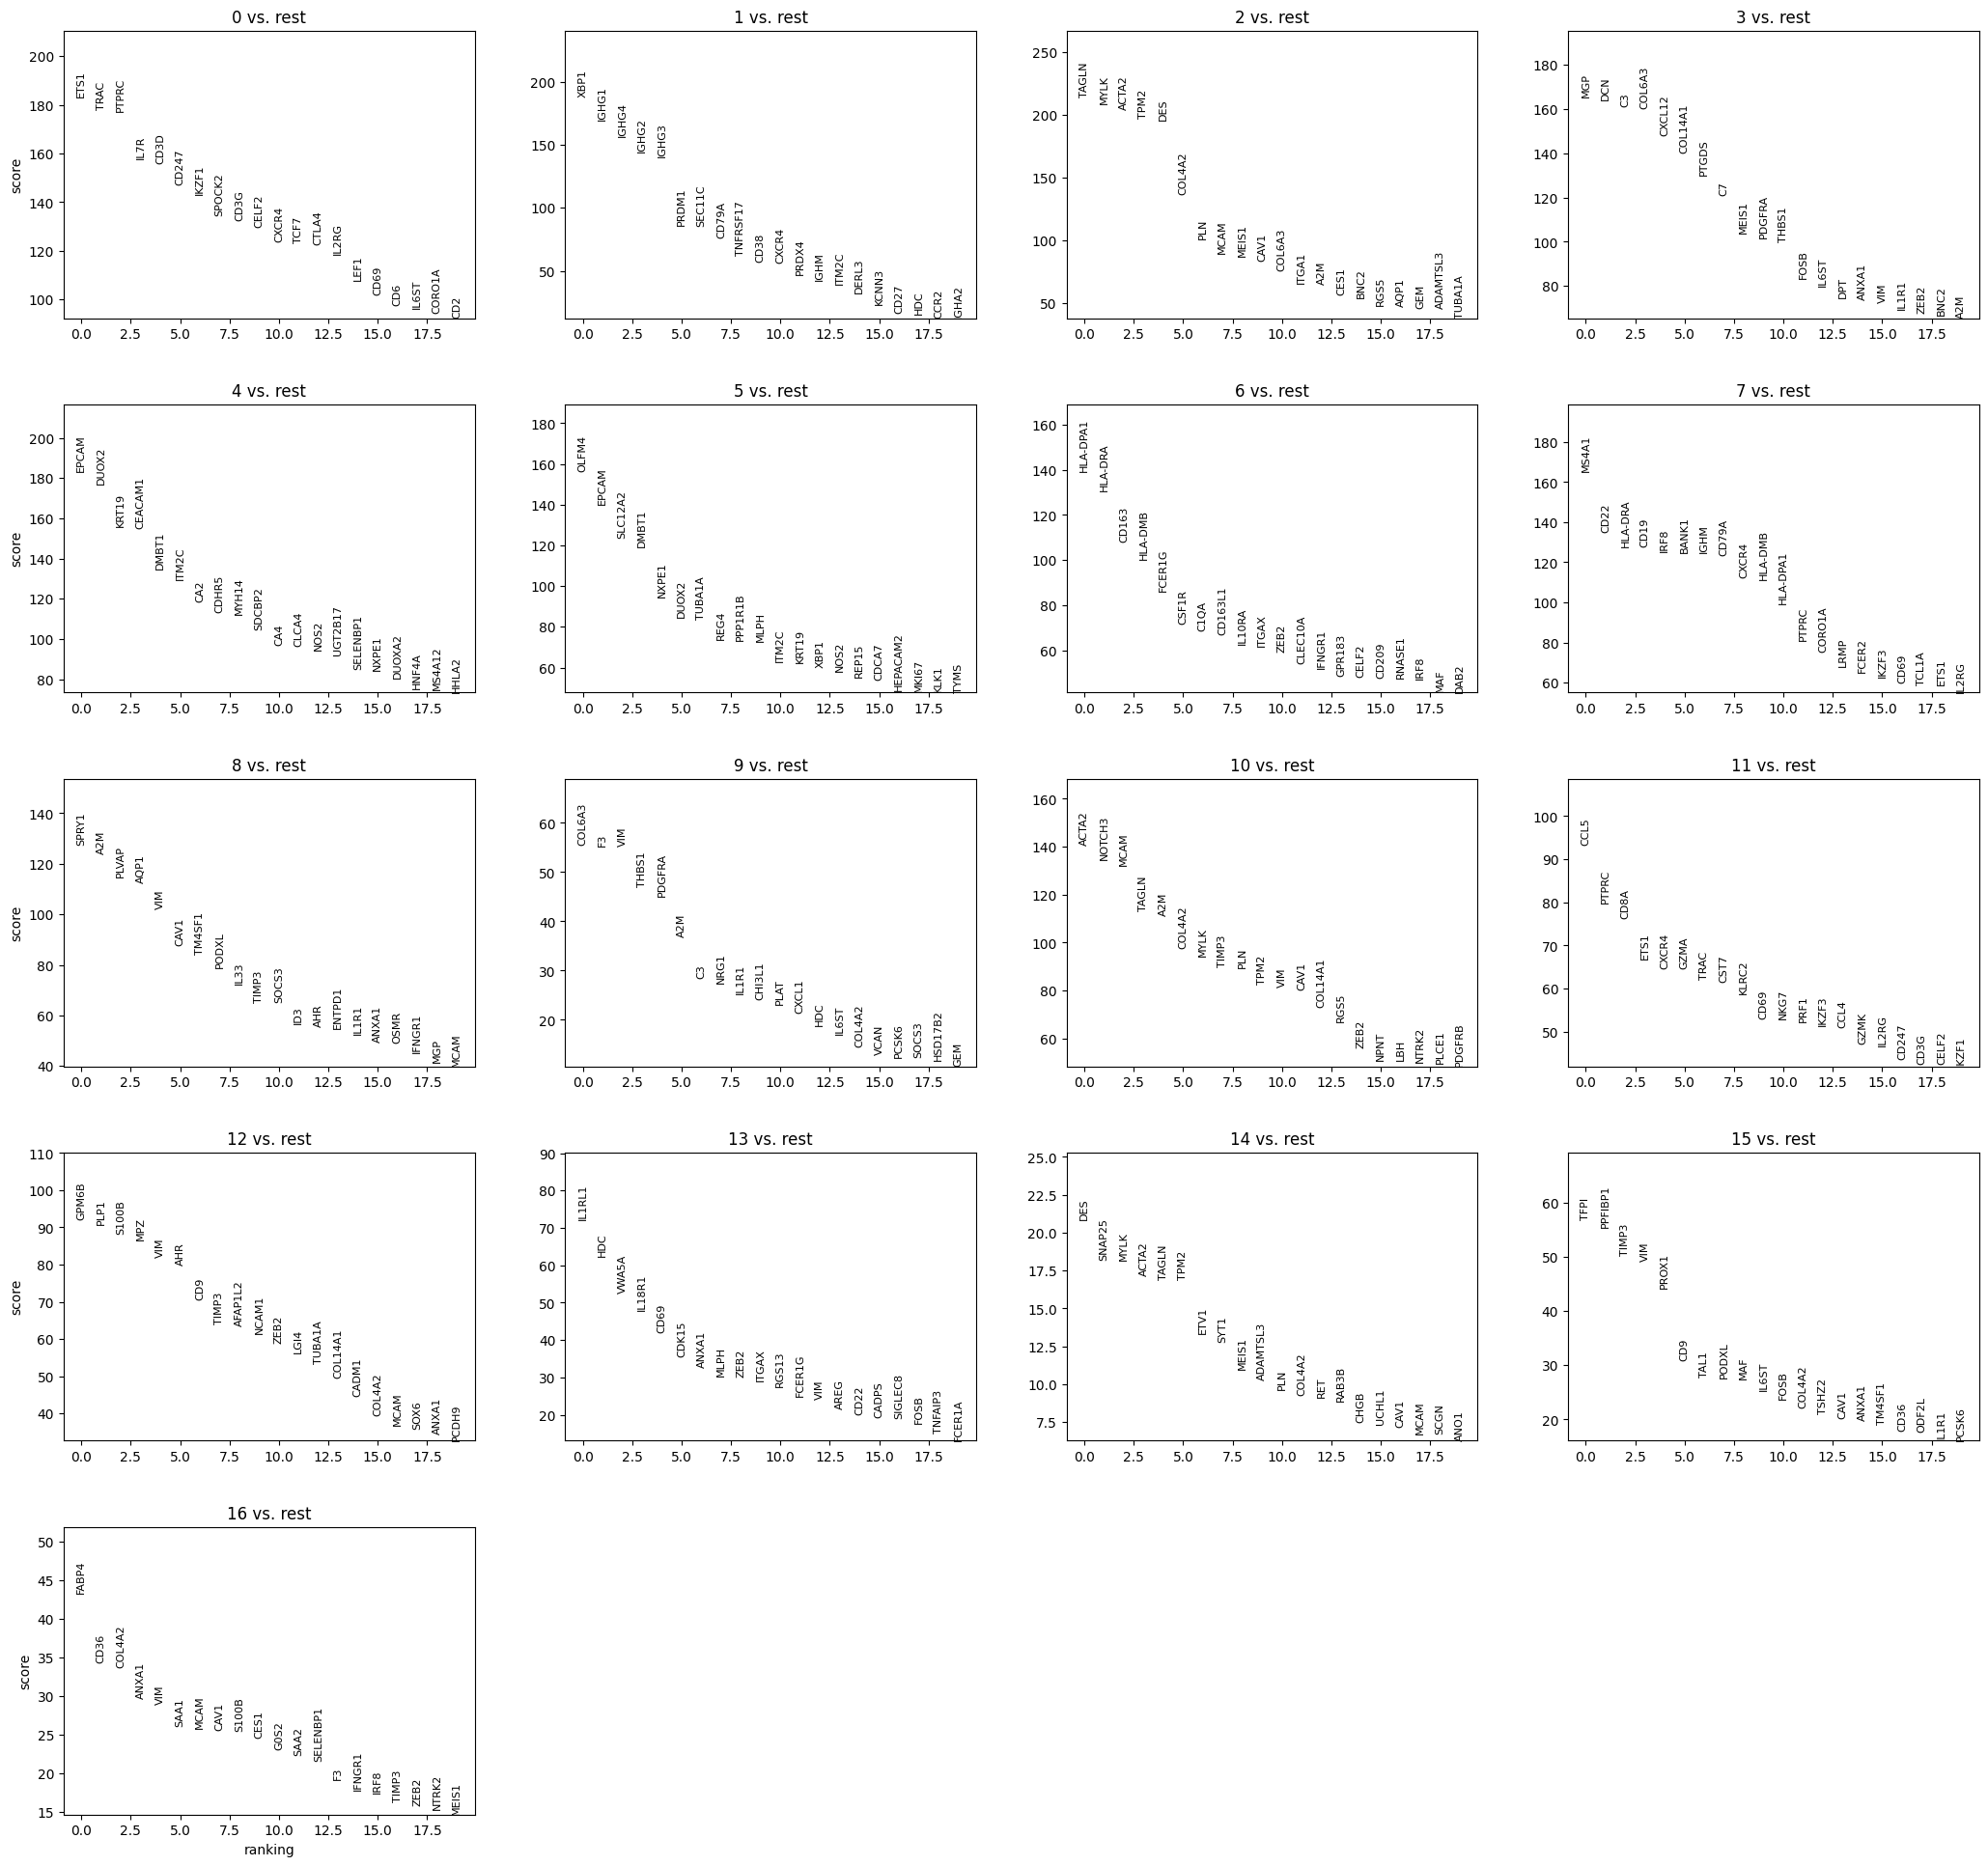

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
from tqdm import tqdm

# Set Scanpy verbosity higher
sc.settings.verbosity = 3  # show more detailed output

# Get gene symbols and expression data
gene_symbols = sdata.tables["anucleus"].var.index.tolist()
expression_data = sdata.tables["anucleus"].layers["counts"]

# Create a pandas DataFrame for expression data
expression_df = pd.DataFrame(expression_data, index=sdata.tables["anucleus"].obs.index, columns=gene_symbols)

# Create AnnData object
adata = sc.AnnData(expression_df.values)
adata.obs.index = sdata.tables["anucleus"].obs.index  # Make sure obs names are correct
adata.var_names = gene_symbols

# Normalize, log-transform, scale
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata)

# PCA
sc.tl.pca(adata, svd_solver='arpack')

# Neighbor graph
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

# Clustering
sc.tl.leiden(adata, resolution=0.5, key_added = 'leiden_0.5')

# UMAP
sc.tl.umap(adata)
sc.pl.umap(adata, color=['leiden_0.5'])  # Visualize in UMAP space

# Marker genes
sc.tl.rank_genes_groups(adata, 'leiden_0.5', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

Using the resolution of 0.5 generated 17 clusters, which may be an overkill. Based on literature, the number of cells that are distinguishable through H&E are 5~8 categories. Hence, we will rerun the analysis by increasing the n_neighbors parameter and lowering the resolution to obtain less granular sub-class.

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:04:58)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:26:32)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:07:38)


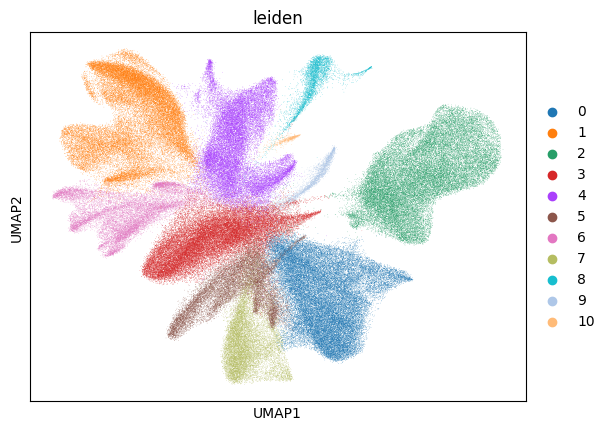

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:10)


/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: 

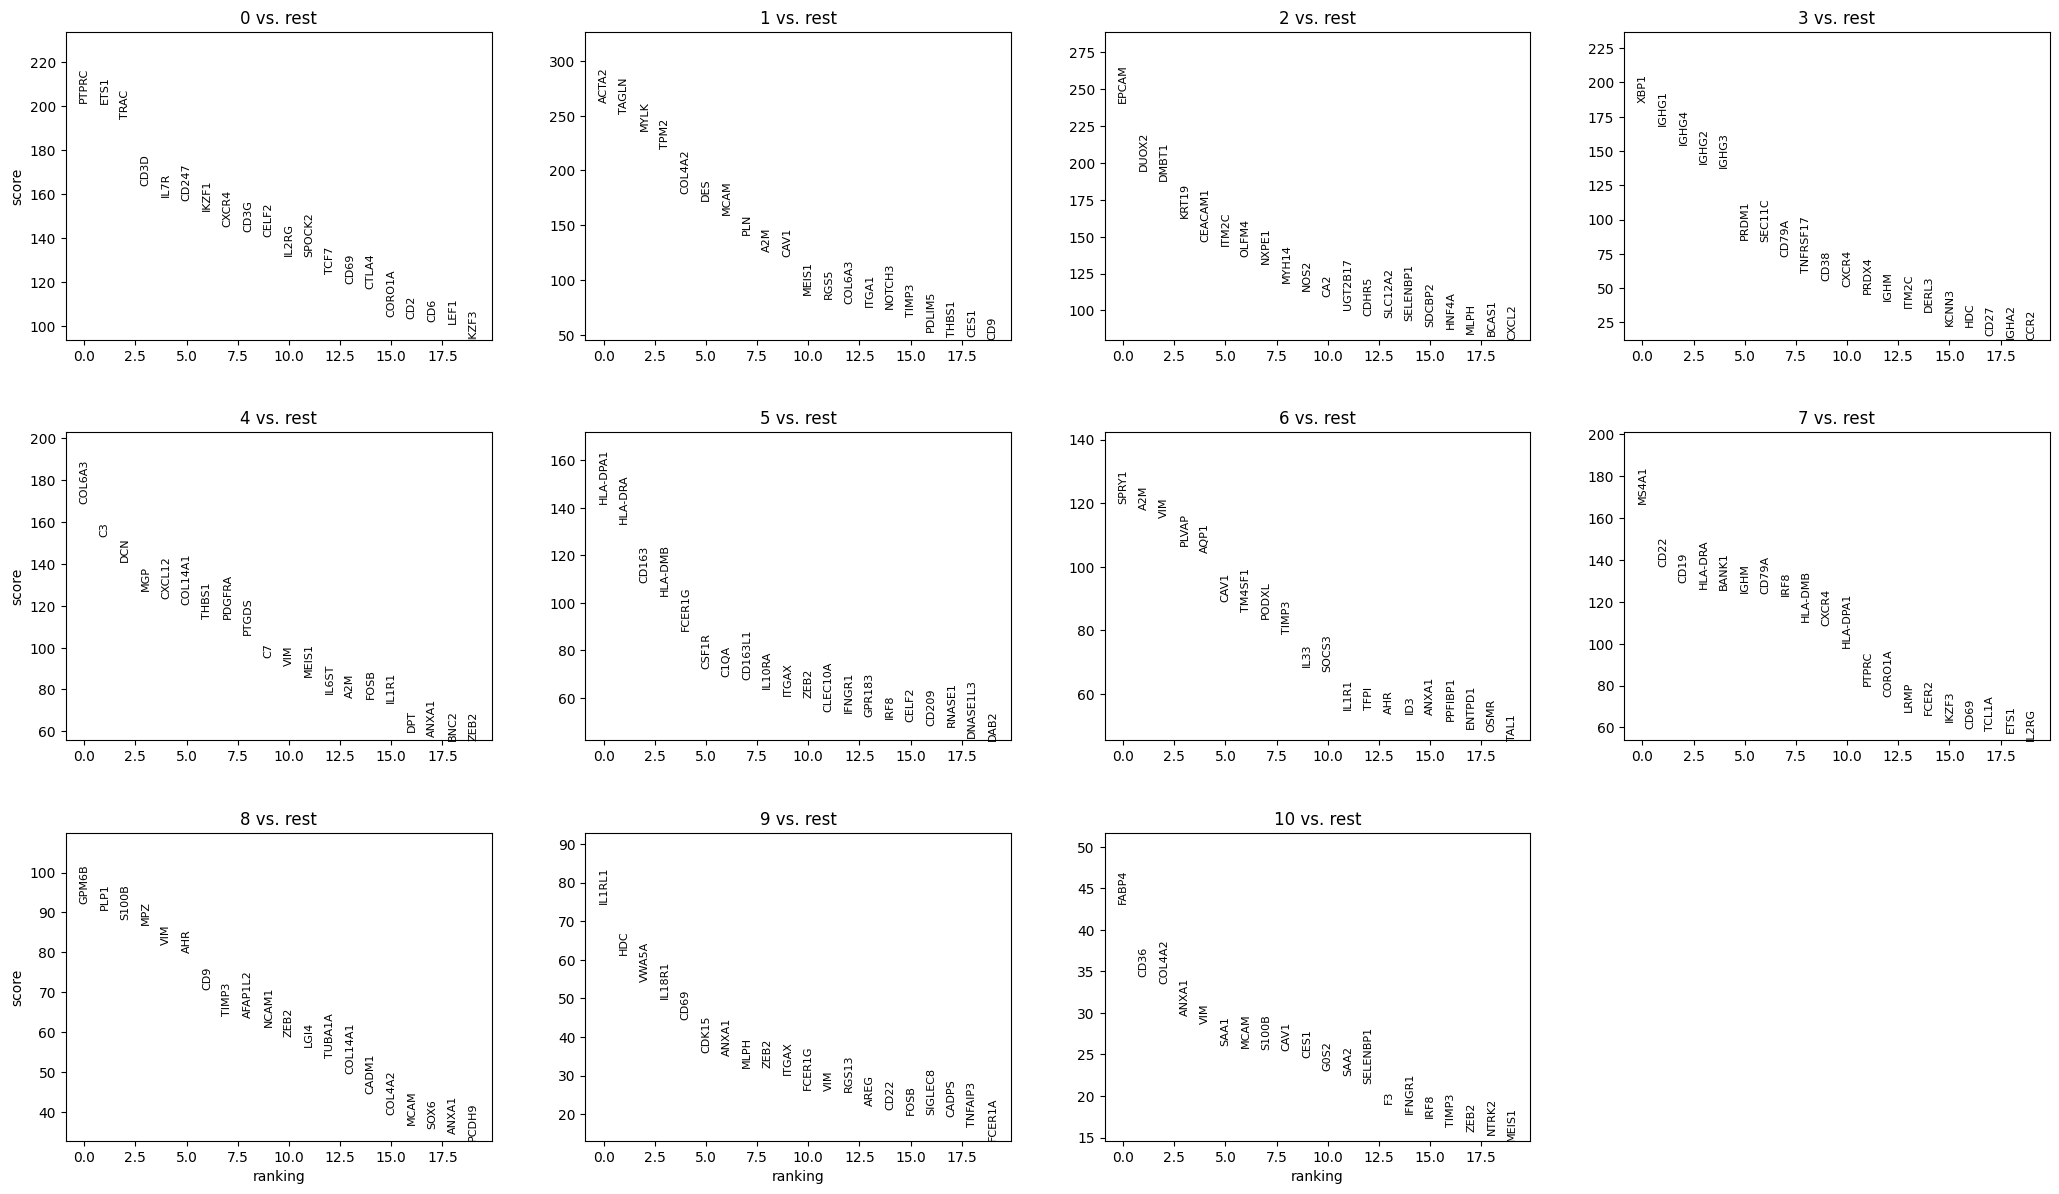

In [ ]:
# Neighbor graph
sc.pp.neighbors(adata, n_neighbors=100, n_pcs=30)

# Clustering
sc.tl.leiden(adata, resolution=0.2, key_added='leiden_0.2')

# UMAP
sc.tl.umap(adata)
sc.pl.umap(adata, color=['leiden_0.2'])  # Visualize in UMAP space

# Marker genes
sc.tl.rank_genes_groups(adata, 'leiden_0.2', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [ ]:
# This is the script that includes mapping to the slides. As this takes a long time (~1 day),
# we will run this script on O2, generate and save the sdata. The saved sdata
# will be used for further analysis.

import numpy as np
import pandas as pd
from joblib import Parallel, delayed

# Get the label mask
label_mask = sdata.images["HE_nuc_original"].to_numpy()[0, :, :]

# Get all unique cell labels (excluding background 0 if necessary)
cell_labels = np.unique(label_mask)
cell_labels = cell_labels[cell_labels != 0]  # if 0 is background

# Define centroid function
def compute_centroid(cell_label):
    y_pixels, x_pixels = np.where(label_mask == cell_label)
    centroid_x = np.mean(x_pixels)
    centroid_y = np.mean(y_pixels)
    return cell_label, centroid_x, centroid_y

# Parallel processing
results = Parallel(n_jobs=-1, verbose=5)(delayed(compute_centroid)(cell_label) for cell_label in cell_labels)

# Unpack results
cell_id_list, centroid_x_list, centroid_y_list = zip(*results)

# Create DataFrame
centroid_df = pd.DataFrame({
    'cell_id': cell_id_list,
    'x': centroid_x_list,
    'y': centroid_y_list
})

In [ ]:
# Get gene symbols and expression data
gene_symbols = sdata.tables["anucleus"].var.index.tolist()
expression_data = sdata.tables["anucleus"].layers["counts"]

# Create a pandas DataFrame for expression data
expression_df = pd.DataFrame(expression_data, index=sdata.tables["anucleus"].obs.index, columns=gene_symbols)
adata = sc.AnnData(expression_df.values)

adata.obs["cell_id"] = sdata.tables["anucleus"].obs
adata.obs["x"] = centroid_df["x"]
adata.obs["y"] = centroid_df["y"]
adata.var_names = gene_symbols

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata)

# PCA
sc.tl.pca(adata, svd_solver='arpack')

# Neighbor graph
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

# Clustering
sc.tl.leiden(adata, resolution=0.5)  # or sc.tl.louvain()

# UMAP (optional)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['leiden'])

# Spatial plot
plt.figure(figsize=(8, 8))
scatter = plt.scatter(adata.obs['x'], adata.obs['y'],
                      c=adata.obs['leiden'].astype(int),
                      cmap='tab20', s=10)
plt.gca().invert_yaxis()
plt.colorbar(scatter)
plt.title('Spatial Clusters')
plt.show()

# Marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

## For what genes are predicting the expression level?

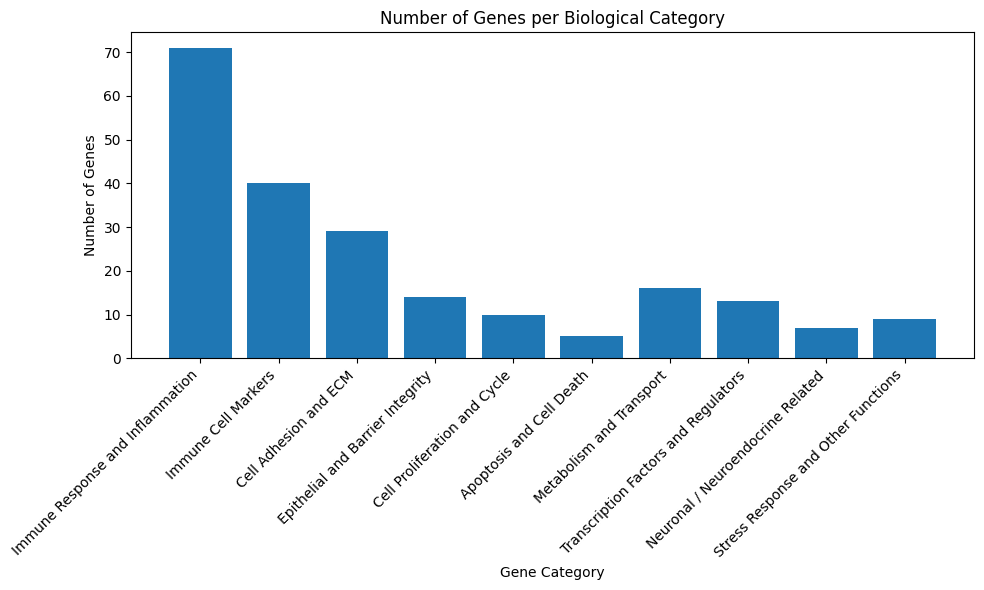

In [ ]:
import matplotlib.pyplot as plt

genes = sdata.tables["anucleus"].var.index.tolist()

# These categories are based on ChatGPT. We only need a general sense of what the
# gene function is. This will provide another layer of interpretability for our model.
gene_categories = {
    "Immune Response and Inflammation": [
        'CCL1', 'CCL2', 'CCL3L1', 'CCL4', 'CCL5', 'CCL7', 'CCL8', 'CCL11', 'CCL13', 'CCL19',
        'CCL20', 'CCL22', 'CCL23', 'CCL24', 'CXCL1', 'CXCL2', 'CXCL3', 'CXCL5', 'CXCL6',
        'CXCL10', 'CXCL11', 'CXCL12', 'CXCL13', 'IL2', 'IL4I1', 'IL5', 'IL5RA', 'IL6', 'IL6R',
        'IL6ST', 'IL7R', 'IL9', 'IL10', 'IL10RA', 'IL10RB', 'IL11', 'IL11RA', 'IL12A', 'IL12B',
        'IL12RB1', 'IL12RB2', 'IL15', 'IL17A', 'IL17RA', 'IL17RC', 'IL17REL', 'IL18', 'IL18R1',
        'IL18RAP', 'IL21', 'IL21R', 'IL22RA1', 'IL23A', 'IL23R', 'IL27RA', 'TNF', 'TNFAIP3',
        'TNFRSF14', 'TNFRSF17', 'TNFSF13B', 'TNFSF14', 'IFNG', 'IFIH1', 'IFNGR1', 'IFNGR2',
        'ISG15', 'C1QA', 'C1QC', 'C3', 'C7', 'FCN1'
    ],
    "Immune Cell Markers": [
        'CD2', 'CD3D', 'CD3G', 'CD4', 'CD5', 'CD6', 'CD7', 'CD8A', 'CD8B', 'TRAC', 'TRDC', 'ICOS',
        'CTLA4', 'PDCD1', 'TIGIT', 'CD19', 'CD22', 'CD79A', 'MS4A1', 'FCRLA', 'CD68', 'CD163',
        'CD163L1', 'CSF1R', 'FCGR3A', 'FCGR3B', 'CD1C', 'CLEC9A', 'CLEC10A', 'CD209', 'KLRB1',
        'KLRC2', 'KLRD1', 'NKG7', 'SELL', 'LST1', 'SIGLEC8', 'HLA-DMB', 'HLA-DPA1', 'HLA-DRA'
    ],
    "Cell Adhesion and ECM": [
        'ITGA1', 'ITGAX', 'MCAM', 'VCAM1', 'VIM', 'TAGLN', 'COL14A1', 'COL4A2', 'COL6A3', 'DCN',
        'ELN', 'MFAP5', 'MGP', 'SPP1', 'THBS1', 'VCAN', 'CAV1', 'CEACAM1', 'CEACAM7', 'ICAM2',
        'ACTA2', 'FNDC1', 'DES', 'S100A4', 'HOPX', 'DPT', 'MMP1', 'MMP3', 'TIMP3'
    ],
    "Epithelial and Barrier Integrity": [
        'EPCAM', 'CDHR5', 'VIL1', 'KRT1', 'KRT19', 'KRT86', 'OLFM4', 'CLCA4', 'CA1', 'CA2', 'CA4',
        'CA7', 'CFTR', 'GUCA2A'
    ],
    "Cell Proliferation and Cycle": [
        'MKI67', 'CDC20', 'CDK1', 'CDK15', 'NUSAP1', 'TOP2A', 'TYMS', 'RRM2', 'UBE2C', 'PTTG1'
    ],
    "Apoptosis and Cell Death": [
        'PRF1', 'GZMA', 'GZMB', 'GZMH', 'GZMK'
    ],
    "Metabolism and Transport": [
        'ALDH1B1', 'SLC12A2', 'FFAR4', 'DUOX2', 'DUOXA2', 'ENTPD1', 'HCAR3', 'HSD17B2', 'PTGDS',
        'PTGIS', 'IDO1', 'COX4I2', 'FABP4', 'PLVAP', 'PLAUR', 'PLAT'
    ],
    "Transcription Factors and Regulators": [
        'BATF', 'FOXP3', 'GATA3', 'ETV1', 'ETS1', 'LEF1', 'SPIB', 'RARA', 'TCF7', 'PRDM1', 'ID2',
        'ID3', 'ZEB2'
    ],
    "Neuronal / Neuroendocrine Related": [
        'SNAP25', 'SYT1', 'CHAT', 'SST', 'SYP', 'PENK', 'NEUROG3'
    ],
    "Stress Response and Other Functions": [
        'S100B', 'S100P', 'S100A4', 'CHI3L1', 'MT1E', 'MT1G', 'MT1M', 'MT1X', 'PRDX4'
    ]
}

category_counts = {category: len(genes_in_cat) for category, genes_in_cat in gene_categories.items()}

plt.figure(figsize=(10, 6))
plt.bar(category_counts.keys(), category_counts.values())
plt.ylabel('Number of Genes')
plt.xlabel('Gene Category')
plt.title('Number of Genes per Biological Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This information may be helpful as we build and test the model. We can identify for which group of genes we are predicting poorly on. This can motivate biological explanations to the model performance!

## Citation
Broad Institute autoimmune disease. CrunchDAO Docs V3. (2024a). https://docs.crunchdao.com/competitions/competitions/broad-institute-autoimmune-disease

"Can you provide me the categorization of the genes based on their pathway involvement/function? Here are the genes: 'A2M', 'ACP5', 'ACTA2', 'ADAMTSL3', 'AFAP1L2', 'AHR', 'ALDH1B1', 'ANO1', 'ANXA1', 'AQP1', 'AQP8', 'AREG', 'ASCL2', 'ATIC', 'AVIL', 'AXL', 'BANK1', 'BATF', 'BCAS1', 'BMX', 'BNC2', 'BTNL9', 'C1QA', 'C1QC', 'C3', 'C7', 'CA1', 'CA2', 'CA4', 'CA7', 'CADM1', 'CADPS', 'CALCB', 'CARD9', 'CAV1', 'CBLB', 'CCK', 'CCL1', 'CCL11', 'CCL13', 'CCL19', 'CCL2', 'CCL20', 'CCL22', 'CCL23', 'CCL24', 'CCL3L1', 'CCL4', 'CCL5', 'CCL7', 'CCL8', 'CCNB1', 'CCR1', 'CCR2', 'CCR3', 'CCR4', 'CCR5', 'CCR6', 'CCR7', 'CCR8', 'CD163', 'CD163L1', 'CD19', 'CD1C', 'CD2', 'CD209', 'CD22', 'CD247', 'CD27', 'CD300E', 'CD36', 'CD38', 'CD3D', 'CD3G', 'CD4', 'CD40LG', 'CD5', 'CD55', 'CD6', 'CD68', 'CD69', 'CD7', 'CD79A', 'CD83', 'CD86', 'CD8A', 'CD8B', 'CD9', 'CDC20', 'CDCA7', 'CDHR5', 'CDK1', 'CDK15', 'CDKN2B', 'CEACAM1', 'CEACAM7', 'CELF2', 'CES1', 'CES2', 'CFTR', 'CHAT', 'CHGB', 'CHI3L1', 'CLC', 'CLCA4', 'CLEC10A', 'CLEC9A', 'CMTM2', 'CNRIP1', 'COL14A1', 'COL4A2', 'COL6A3', 'CORO1A', 'COX4I2', 'CRTAM', 'CSF1R', 'CSF3', 'CST7', 'CSTA', 'CTLA4', 'CXCL1', 'CXCL10', 'CXCL11', 'CXCL12', 'CXCL13', 'CXCL2', 'CXCL3', 'CXCL5', 'CXCL6', 'CXCR1', 'CXCR2', 'CXCR3', 'CXCR4', 'CXCR5', 'CXCR6', 'DAB2', 'DCN', 'DEFB4A', 'DERL3', 'DES', 'DMBT1', 'DNASE1L3', 'DOK2', 'DPT', 'DUOX2', 'DUOXA2', 'EBI3', 'ELN', 'ENTPD1', 'EP300', 'EPCAM', 'EREG', 'ETS1', 'ETV1', 'F3', 'FABP4', 'FCER1A', 'FCER1G', 'FCER2', 'FCGR3A', 'FCGR3B', 'FCN1', 'FCRLA', 'FFAR4', 'FNDC1', 'FOLR2', 'FOSB', 'FOXP3', 'FRZB', 'G0S2', 'GATA3', 'GEM', 'GIP', 'GJA4', 'GNA11', 'GPC3', 'GPM6B', 'GPR183', 'GPR35', 'GUCA2A', 'GZMA', 'GZMB', 'GZMH', 'GZMK', 'HAPLN1', 'HBEGF', 'HCAR3', 'HDC', 'HEPACAM2', 'HEY1', 'HHLA2', 'HIGD1B', 'HLA-DMB', 'HLA-DPA1', 'HLA-DRA', 'HMGB2', 'HNF4A', 'HOPX', 'HSD17B2', 'ICAM2', 'ICOS', 'ID2', 'ID3', 'IDO1', 'IFIH1', 'IFNG', 'IFNGR1', 'IFNGR2', 'IGFBP6', 'IGHA2', 'IGHG1', 'IGHG2', 'IGHG3', 'IGHG4', 'IGHM', 'IKZF1', 'IKZF3', 'IL10', 'IL10RA', 'IL10RB', 'IL11', 'IL11RA', 'IL12A', 'IL12B', 'IL12RB1', 'IL12RB2', 'IL15', 'IL17A', 'IL17RA', 'IL17RC', 'IL17REL', 'IL18', 'IL18R1', 'IL18RAP', 'IL1R1', 'IL1R2', 'IL1RAP', 'IL1RL1', 'IL2', 'IL21', 'IL21R', 'IL22RA1', 'IL23A', 'IL23R', 'IL27RA', 'IL2RA', 'IL2RB', 'IL2RG', 'IL33', 'IL4I1', 'IL5', 'IL5RA', 'IL6', 'IL6R', 'IL6ST', 'IL7R', 'IL9', 'IMPDH2', 'IRF8', 'ISG15', 'ITGA1', 'ITGAX', 'ITLN2', 'ITM2C', 'KCNIP4', 'KCNN3', 'KLK1', 'KLRB1', 'KLRC2', 'KLRD1', 'KRT1', 'KRT19', 'KRT86', 'LBH', 'LEF1', 'LEFTY1', 'LGALS2', 'LGI4', 'LGR5', 'LRMP', 'LRRK2', 'LST1', 'LTB', 'LY6H', 'MAF', 'MARCKSL1', 'MATK', 'MBP', 'MCAM', 'MEFV', 'MEIS1', 'MFAP5', 'MGP', 'MKI67', 'MLPH', 'MMP1', 'MMP3', 'MPO', 'MPZ', 'MR1', 'MS4A1', 'MS4A12', 'MS4A3', 'MSLN', 'MT1E', 'MT1G', 'MT1M', 'MT1X', 'MYH14', 'MYLK', 'NCAM1', 'NDUFA4L2', 'NEUROG3', 'NKG7', 'NKX2-3', 'NMU', 'NOD2', 'NOS1', 'NOS2', 'NOSIP', 'NOTCH3', 'NOVA1', 'NPNT', 'NRG1', 'NTRK2', 'NUSAP1', 'NXPE1', 'ODF2L', 'OLFM4', 'OSM', 'OSMR', 'P2RY1', 'PCDH9', 'PCNA', 'PCSK6', 'PDCD1', 'PDGFRA', 'PDGFRB', 'PDLIM5', 'PENK', 'PF4', 'PGLYRP1', 'PI16', 'PID1', 'PKIB', 'PLAT', 'PLAUR', 'PLCE1', 'PLN', 'PLP1', 'PLVAP', 'PODXL', 'PPFIBP1', 'PPP1R1B', 'PRDM1', 'PRDX4', 'PRF1', 'PRG2', 'PROK2', 'PROX1', 'PTAFR', 'PTGDS', 'PTGIS', 'PTPN22', 'PTPRC', 'PTTG1', 'RAB3B', 'RANBP1', 'RARA', 'RBFOX1', 'RBP7', 'REG1B', 'REG4', 'REP15', 'RET', 'RETN', 'RGCC', 'RGS13', 'RGS5', 'RNASE1', 'RNASE2', 'RORC', 'RRM2', 'RSPO3', 'S100A4', 'S100B', 'S100P', 'SAA1', 'SAA2', 'SCGN', 'SCMH1', 'SDCBP2', 'SEC11C', 'SELE', 'SELENBP1', 'SELL', 'SEMA3G', 'SGCZ', 'SIGLEC8', 'SLC12A2', 'SLIT2', 'SMIM14', 'SNAP25', 'SNCA', 'SOCS3', 'SOSTDC1', 'SOX6', 'SPIB', 'SPOCK2', 'SPP1', 'SPRY1', 'SST', 'STEAP4', 'STMN1', 'SULT1B1', 'SYP', 'SYT1', 'TAGLN', 'TAL1', 'TCF7', 'TCL1A', 'TFF1', 'TFPI', 'TGFB1', 'THBS1', 'TIGIT', 'TIMP3', 'TK1', 'TM4SF1', 'TNF', 'TNFAIP3', 'TNFRSF14', 'TNFRSF17', 'TNFSF13B', 'TNFSF14', 'TOP2A', 'TPH1', 'TPM2', 'TRAC', 'TRAT1', 'TRDC', 'TSHZ2', 'TSLP', 'TUBA1A', 'TUBB', 'TYMS', 'UBE2C', 'UCHL1', 'UGT2B17', 'VCAM1', 'VCAN', 'VIL1', 'VIM', 'VPREB3', 'VWA5A', 'WFDC2', 'XBP1', 'XCL2', 'XCR1', 'ZEB2'" prompt. ChatGPT 4o, OpenAI, 18 April 2025, chat.openai.com/chat.